In [103]:
# 验证路径设置
%matplotlib inline
import os
import sys
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import query_to_wechat


# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: c:\Users\theli\Documents\GitHub\stock_project\.venv\Scripts\python.exe
Project root: c:\Users\theli\Documents\GitHub\stock_project
✅ 模块导入成功！


In [ ]:
# 下载股票数据
start_date = '2025-10-01'
end_date = '2025-12-31'
period = '3mo'
interval = '1h'
ticker = ['RGTI']

current_position = '当前持仓: 空头，占总仓位21%，均价 $56.08。'
current_position = '当前未开仓。'

df = download_stock_data( ticker , start_date , end_date , period=period, interval=interval)
df.head()

[*********************100%***********************]  1 of 1 completed
c:\Users\theli\Documents\GitHub\stock_project\src\downloader.ipynb:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].replace(0, np.nan).fillna(method='ffill')  # 处理成交量为0的情况


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile
Datetime,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,75.540001,77.559998,74.309998,75.680000,4125954,NaN,NaN,4.373570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.849998,0.0,4125954
2025-08-13 14:30:00+00:00,75.650002,75.650002,72.860001,73.699997,1995407,-2.616283,-0.026511,3.829263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.269764,0.0,2130547
2025-08-13 15:30:00+00:00,73.739502,74.717903,73.300003,73.750000,1204215,0.067847,0.000678,1.934379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.048317,0.0,3334762
2025-08-13 16:30:00+00:00,73.754997,73.779999,72.839996,73.418800,926686,-0.449084,-0.004501,1.290503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.857185,0.0,2408076
2025-08-13 17:30:00+00:00,73.419998,74.738503,72.980003,74.720001,773169,1.772299,0.017568,2.409563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.796275,0.0,3181245


c:\Users\theli\Documents\GitHub\stock_project\src\visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


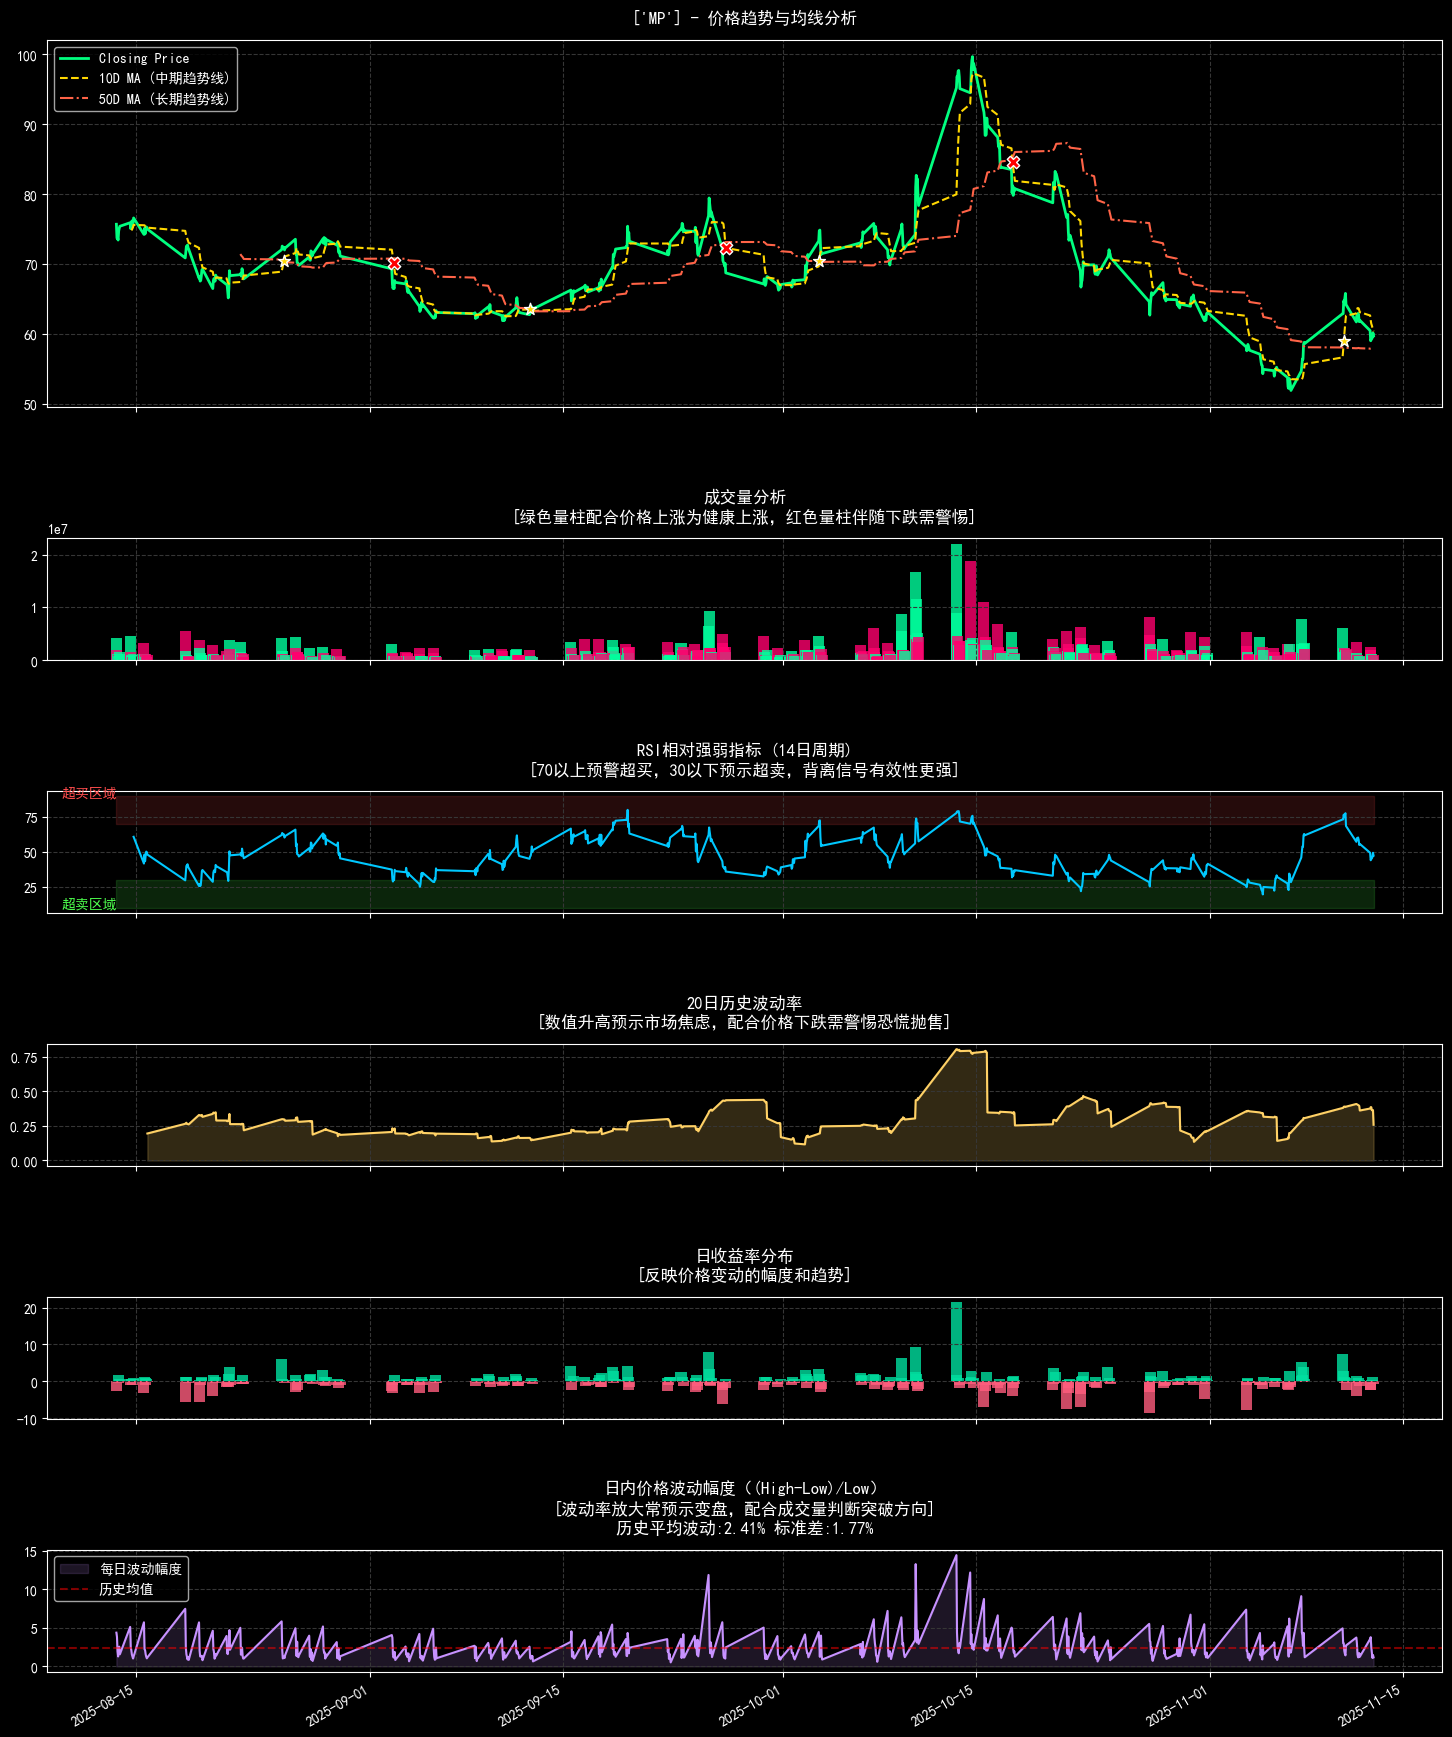

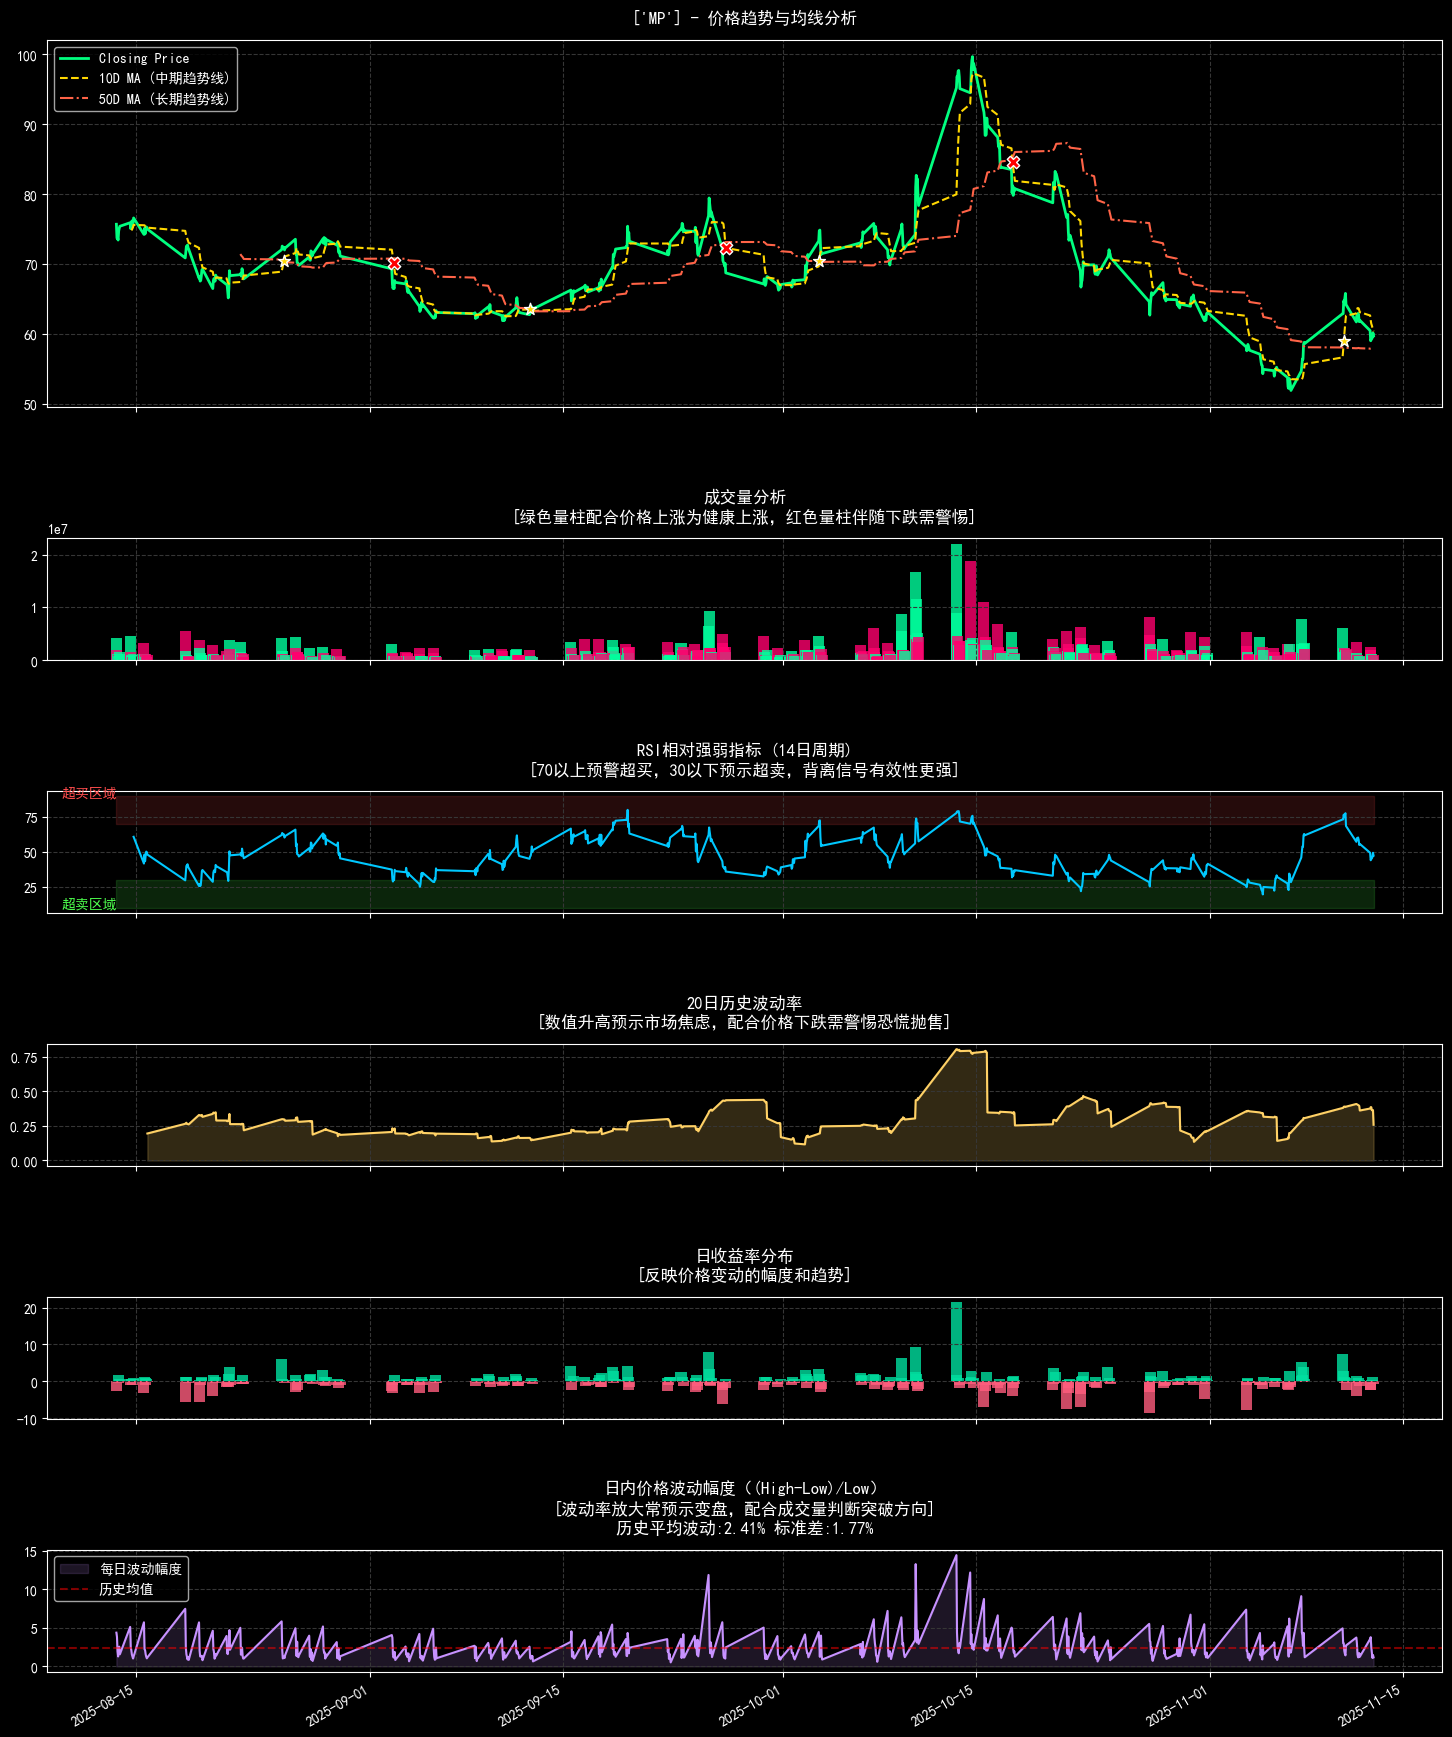

In [105]:
plot_technical(df,ticker)

In [106]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，这是{ticker}从{start_date}到{end_date}的交易数据。{current_position}
    请用简单专业的语言分析{ticker[0]}的走势及其多/空投资机会及操作建议（请在操作建议时，附上信心指数，<20不建议操作；20-40观望；40-60可以清仓，及时止损；60-80可以开始逐步建仓；>80强烈信号，或可以立即操作）：
    {latest}
    如果你认为提供更多技术指标会有帮助，请告诉我有哪些，我会补充。
    """
    
    # 步骤3：调用Deepseek API并解析结果
    # try:
    notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("\\")[-2]
    project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
    client = OpenAI(
            api_key='sk-svlwkvpmiesxltcrmogahgwdpsucauiqdvdrgssmogbtujvh',
            base_url='https://api.siliconflow.cn/v1'
            )
    
    completion = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 8192,
        temperature = 0.3
    )
    # 解析响应
    response_message = completion.choices[0].message

    # 提取回答和思考内容
    answer = response_message.content
    reasoning = response_message.reasoning_content

    # 格式化输出，只显示回答，不显示思考
    formatted_output = f'{answer.strip()}'

    output_file = "temp_output.md"
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("# DeepSeek 分析报告\n\n")
        f.write("## 数据摘要\n")
        f.write(data_summary + "\n\n")
        f.write("## 分析结果\n")
        f.write(formatted_output + "\n")
    os.system(f'code {output_file}')  # 在默认Markdown查看器中打开文件
    
    return print(data_summary + "\n" + formatted_output)
        
    # except Exception as e:
    #     print(f"模型调用失败: {str(e)}")
    #     return "暂无分析结果"

In [ ]:
message = get_deepseek_analysis(df)
print(message)
query_to_wechat.send_with_retry(title=message)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile,MA10_above_MA50
Datetime,,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,37.650002,38.040001,36.770000,37.625000,4363785,NaN,NaN,3.453904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.478334,0.0,4363785,False
2025-08-13 14:30:00+00:00,37.630001,37.709999,37.240002,37.480000,1709236,-0.385383,-0.003861,1.262077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.477865,0.0,2654549,False
2025-08-13 15:30:00+00:00,37.480000,37.509998,36.709999,36.720001,1657183,-2.027744,-0.020486,2.179241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371133,0.0,997366,False
2025-08-13 16:30:00+00:00,36.730000,37.200001,36.520000,37.009998,1406918,0.789752,0.007867,1.861994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.300129,0.0,2404284,False
2025-08-13 17:30:00+00:00,37.029999,37.342300,36.970001,37.302200,1063403,0.789522,0.007864,1.007031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.290194,0.0,3467687,False


In [ ]:
def generate_report(ticker,start_date,end_date, period=None):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date, period)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


In [ ]:
generate_report(ticker,start_date,end_date, period=period)

TypeError: expected string or bytes-like object, got 'list'